# Importance sampling

In this notebook, we use importance sampling to approximate the posterior distribution of the latent variables in a Non-Markovian Gaussian sequence model.

We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t \big\vert \sum_{k=1}^t \beta^{t-k} x_k, r\right).
\end{aligned}
$$

Suppose we know the values $\boldsymbol\theta = (\phi, q, \beta, r)$ that govern the sequence model. 

In [172]:
%load_ext autoreload
%autoreload 2

In [375]:
import jax
import distrax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jsmc.datagen import non_markovian_gsm as nmgsm

In [159]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [405]:
key = jax.random.PRNGKey(314)
num_steps = 50
params = nmgsm.ModelParameters(phi=0.0, q=0.4, beta=0.0, r=1.0)
simulation = nmgsm.simulate(key, params, num_steps)

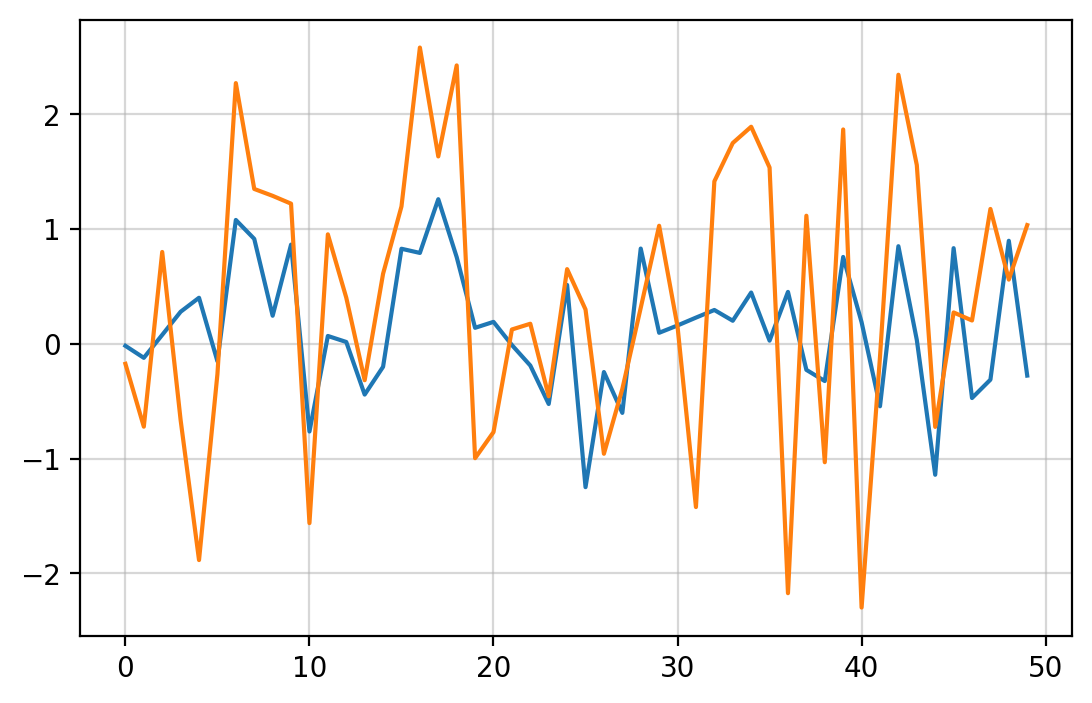

In [406]:
plt.plot(simulation.x)
plt.plot(simulation.y)
plt.grid(alpha=0.5)

## Posterior estimation

In [407]:
vals = jnp.tri(num_steps)

In [408]:
def step_target_t(carry_row, row, beta=2):
    """
    Building non-markovian ssm: one row at a time
    """
    carry_row = carry_row * beta + row
    return carry_row, carry_row

In [409]:
num_steps_test= 10
init_row = jnp.zeros(num_steps_test)
vals = jnp.eye(num_steps_test)

jax.lax.scan(step_target_t, init_row, vals)[1]

DeviceArray([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
             [ 16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.],
             [ 32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.],
             [ 64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.],
             [128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.],
             [256., 128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.],
             [512., 256., 128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.]],            dtype=float32)

## Evaluating log-joint

In [410]:
mean_proposal = jnp.zeros(num_steps)
scale_proposal = jnp.ones(num_steps) * 0.5
proposal = distrax.MultivariateNormalDiag(loc=mean_proposal, scale_diag=scale_proposal)
x_prop = proposal.sample(seed=key)

In [411]:
nmgsm.log_joint(simulation.x, simulation.y, params)

DeviceArray(-139.67526, dtype=float32)

In [412]:
nmgsm.log_joint(x_prop, simulation.y, params)

DeviceArray(-144.81886, dtype=float32)

In [413]:
@partial(jax.vmap, in_axes=(0, None, None))
def get_log_weights(x_latent, y_obs, params):
    return nmgsm.log_joint(x_latent, y_obs, params) - proposal.log_prob(x_latent)

In [424]:
n_particles = 1_000
scale_proposal = jnp.ones(num_steps)
x_prop = proposal.sample(seed=key, sample_shape=(n_particles,))
log_weights = get_log_weights(x_prop, simulation.y, params)
log_weights[:50]

DeviceArray([-100.00159 , -115.617134, -100.98807 , -115.135895,
             -108.57494 , -119.06303 , -119.90644 , -110.50199 ,
             -109.17824 , -116.06186 , -103.96879 , -109.027794,
             -106.2867  , -119.29879 , -110.83572 , -118.98658 ,
             -106.24812 , -103.7341  , -116.58022 , -121.88726 ,
             -109.02769 , -128.06482 , -113.08634 , -124.80783 ,
             -103.13525 , -105.75583 , -104.52463 , -102.18532 ,
             -122.07601 , -114.72863 , -108.020065, -115.24974 ,
              -97.87279 , -106.51282 , -114.09031 , -123.496826,
             -108.57395 , -120.07596 , -109.28632 , -122.87177 ,
             -114.06086 , -125.895256,  -99.332794, -105.657295,
             -117.78875 , -108.76216 , -112.36773 , -113.3622  ,
             -103.27589 , -105.13399 ], dtype=float32)

In [425]:
logz = jax.vmap(nmgsm.log_joint, in_axes=(0, None, None))(x_prop, simulation.y, params)
logz_true = nmgsm.log_joint(simulation.x, simulation.y, params)
logz_diff = logz - logz_true

<AxesSubplot: >

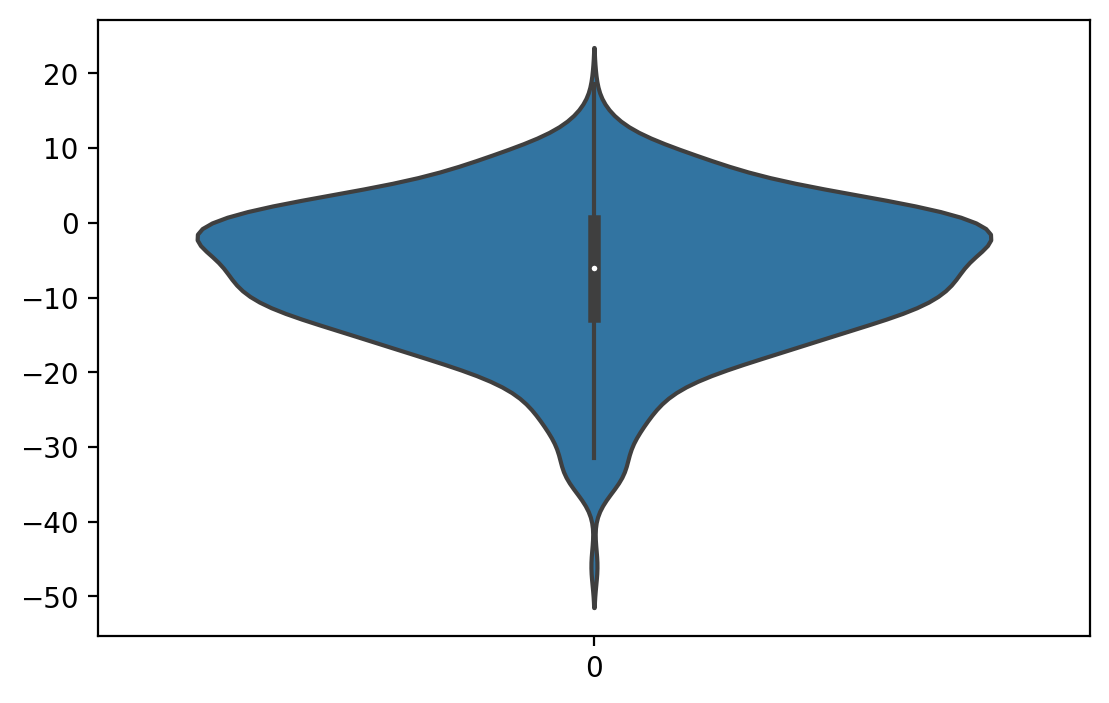

In [426]:
sns.violinplot(logz_diff.to_py())

In [427]:
weights = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))
x_est = jnp.einsum("sm,s->m", x_prop, weights)

In [428]:
nmgsm.log_joint(simulation.x, simulation.y, params)

DeviceArray(-139.67526, dtype=float32)

In [429]:
nmgsm.log_joint(x_est, simulation.y, params)

DeviceArray(-108.391914, dtype=float32)